### **Comparison of GAN with miniBatch GAN**
#### Deep Learning course - IASBS

In this exercise, a GAN and a MiniBatch GAN are implemented in Keras for MNIST and CFar10 image datasets.

This comparison code has been developed with help of multipule good references and webpages including [David Gündisch's blog post](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)

Importing dependencies


In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


GAN class

In [ ]:
# initializing GAN class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)      
        # build Discriminator  
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])        
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        
        # build Generator
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)

        # Connection between Gnerator and Discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # Defining Discriminator's model
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    #Defining Generator Model
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    # Training process
    def train(self, epochs, batch_size=128, sample_interval=50):

        (X_train, _), (_, _) = mnist.load_data()        

        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):    
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]    

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))    

                gen_imgs = self.generator.predict(noise)    

                # train discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # train Generator
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                if epoch % sample_interval == 0:
                        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                        # self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                cnt += 1
        # fig.savefig("images/%d.png" % epoch)
        axis('off')
        plt.close()



In [ ]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=100000, batch_size=132, sample_interval=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.680555, acc.: 57.20%] [G loss: 0.596861]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.323841, acc.: 86.74%] [G loss: 3.436708]
200 [D loss: 0.484669, acc.: 74.62%] [G loss: 2.248201]
300 [D loss: 0.681283, acc.: 45.08%] [G loss: 0.650609]
400 [D loss: 0.655294, acc.: 48.48%] [G loss: 0.687623]
500 [D loss: 0.633566, acc.: 67.05%] [G loss: 0.739405]
600 [D loss: 0.610872, acc.: 65.53%] [G loss: 0.809245]
700 [D loss: 0.616715, acc.: 64.02%] [G loss: 0.846246]
800 [D loss: 0.636560, acc.: 67.05%] [G loss: 0.930056]
900 [D loss: 0.579529, acc.: 74.62%] [G loss: 0.956010]
1000 [D loss: 0.587859, acc.: 69.70%] [G loss: 1.067846]
1100 [D loss: 0.569771, acc.: 81.06%] [G loss: 0.994203]
1200 [D loss: 0.574119, acc.: 75.38%] [G loss: 1.035851]
1300 [D loss: 0.548979, acc.: 78.03%] [G loss: 1.063194]
1400 [D loss: 0.563725, acc.: 71.59%] [G loss: 1.150082]
1500 [D loss: 0.581164, acc.: 70.08%] [G loss: 1.159343]
1600 [D loss: 0.531680, acc.: 79.17%] [G loss: 1.175379]
1700 [D loss: 0.518865, acc.: 77.27%] [G loss: 1.154722]
1800 [D loss: 0.512937, acc.: 78.79%] [G

NameError: ignored

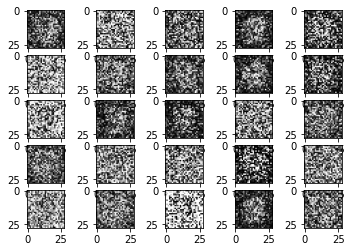

In [ ]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        cnt += 1
# fig.savefig("images/%d.png" % epoch)
axis('off')
plt.close()

In [ ]:
!pip install tensorflow==1.15